### Installing Dependencies

In [3]:
!git clone https://github.com/ibaiGorordo/Sapiens-Pytorch-Inference.git

Cloning into 'Sapiens-Pytorch-Inference'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 157 (delta 101), reused 103 (delta 52), pack-reused 0 (from 0)
Receiving objects: 100% (157/157), 2.87 MiB | 7.93 MiB/s, done.
Resolving deltas: 100% (101/101), done.


In [1]:
%cd Sapiens-Pytorch-Inference

/workspace/Sapiens-Pytorch-Inference


/opt/conda/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
!pip install -r requirements.txt -q

In [6]:
pwd

'/workspace/Sapiens-Pytorch-Inference'

In [2]:
import os
import sys
import shutil
from typing import List
import requests
from tqdm import tqdm
from datetime import timedelta

from enum import Enum
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imread_from_url import imread_from_url

from dataclasses import dataclass
from torchvision import transforms
import torch
import torch.nn.functional as F

from huggingface_hub import hf_hub_download, hf_hub_url

### Download Test Images

In [3]:
import os
os.makedirs("test_images/", exist_ok = True)

!wget -nc https://learnopencv.com/wp-content/uploads/2024/09/man-horse-arrow-scaled.jpg -O test_images/man-horse-arrow.jpg

!wget -nc https://learnopencv.com/wp-content/uploads/2024/09/football-soccer-scaled.jpg -O test_images/football.jpg
!wget -nc https://learnopencv.com/wp-content/uploads/2024/09/jogging-1-scaled.jpg -O test_images/jogging.jpg

!wget -nc https://learnopencv.com/wp-content/uploads/2024/09/Sapiens-video-test.mp4 -O test_images/Sapiens-video-test.mp4


--2024-09-22 14:20:53--  https://learnopencv.com/wp-content/uploads/2024/09/man-horse-arrow-scaled.jpg
Resolving learnopencv.com (learnopencv.com)... 172.66.41.41, 172.66.42.215, 2606:4700:3108::ac42:2ad7, ...
Connecting to learnopencv.com (learnopencv.com)|172.66.41.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109854 (107K) [image/jpeg]
Saving to: ‘test_images/man-horse-arrow.jpg’

test_images/man-hor 100%[===================>] 107.28K  --.-KB/s    in 0.02s   

2024-09-22 14:20:54 (4.57 MB/s) - ‘test_images/man-horse-arrow.jpg’ saved [109854/109854]

--2024-09-22 14:20:54--  https://learnopencv.com/wp-content/uploads/2024/09/football-soccer-scaled.jpg
Resolving learnopencv.com (learnopencv.com)... 172.66.42.215, 172.66.41.41, 2606:4700:3108::ac42:2929, ...
Connecting to learnopencv.com (learnopencv.com)|172.66.42.215|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82891 (81K) [image/jpeg]
Saving to: ‘test_images/football.jpg’



### Download Sapiens-1B Model for all tasks

In [4]:
!wget -nc https://huggingface.co/facebook/sapiens-normal-1b-torchscript/resolve/main/sapiens_1b_normal_render_people_epoch_115_torchscript.pt2  -O models/sapiens_1b_normal_render_people_epoch_115_torchscript.pt2

!wget -nc https://huggingface.co/facebook/sapiens-seg-1b-torchscript/resolve/main/sapiens_1b_goliath_best_goliath_mIoU_7994_epoch_151_torchscript.pt2 -O models/sapiens_1b_goliath_best_goliath_mIoU_7994_epoch_151_torchscript.pt2

!wget -nc https://huggingface.co/facebook/sapiens-depth-1b-torchscript/resolve/main/sapiens_1b_render_people_epoch_88_torchscript.pt2 -O models/sapiens_1b_render_people_epoch_88_torchscript.pt2

!wget -nc https://huggingface.co/facebook/sapiens-pose-1b-torchscript/resolve/main/sapiens_1b_goliath_best_goliath_AP_640_torchscript.pt2 -O models/sapiens_1b_goliath_best_goliath_AP_640_torchscript.pt2

--2024-09-22 14:21:00--  https://huggingface.co/facebook/sapiens-normal-1b-torchscript/resolve/main/sapiens_1b_normal_render_people_epoch_115_torchscript.pt2
Resolving huggingface.co (huggingface.co)... 18.160.102.4, 18.160.102.86, 18.160.102.96, ...
Connecting to huggingface.co (huggingface.co)|18.160.102.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/16/3e/163ec28269ad2e6897e2dd1ada8f1ce2f1a85d0e85f5c9f9572b924fd25e0aeb/00e29d62c385de04f40bc188dd4571e19cab26a8dbc1424d61a77206b3758fb2?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27sapiens_1b_normal_render_people_epoch_115_torchscript.pt2%3B+filename%3D%22sapiens_1b_normal_render_people_epoch_115_torchscript.pt2%22%3B&Expires=1727274060&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyNzI3NDA2MH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzE2LzNlLzE2M2VjMjgyNjlhZDJlNjg5N2UyZG

### Common Utilities

In [3]:
class TaskType(Enum):
    DEPTH = "depth"
    NORMAL = "normal"
    SEG = "seg"


def download(url: str, filename: str):
    with open(filename, 'wb') as f:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            total = int(r.headers.get('content-length', 0))

            # tqdm has many interesting parameters. Feel free to experiment!
            tqdm_params = {
                'total': total,
                'miniters': 1,
                'unit': 'B',
                'unit_scale': True,
                'unit_divisor': 1024,
            }
            with tqdm(**tqdm_params) as pb:
                for chunk in r.iter_content(chunk_size=8192):
                    pb.update(len(chunk))
                    f.write(chunk)


def download_hf_model(model_name: str, task_type: TaskType, model_dir: str = 'models'):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    path = model_dir + "/" + model_name
    if os.path.exists(path):
        return path

    print(f"Model {model_name} not found, downloading from Hugging Face Hub...")

    model_version = "_".join(model_name.split("_")[:2])
    repo_id = "facebook/sapiens"
    subdirectory = f"sapiens_lite_host/torchscript/{task_type.value}/checkpoints/{model_version}"

    # hf_hub_download(repo_id=repo_id, filename=model_name, subfolder=subdirectory, local_dir=model_dir)
    url = hf_hub_url(repo_id=repo_id, filename=model_name, subfolder=subdirectory)
    download(url, path)
    print("Model downloaded successfully to", path)

    return path


def create_preprocessor(input_size: tuple[int, int],
                        mean: List[float] = (0.485, 0.456, 0.406),
                        std: List[float] = (0.229, 0.224, 0.225)):
    return transforms.Compose([transforms.ToPILImage(),
                               transforms.Resize(input_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=mean, std=std),
                               transforms.Lambda(lambda x: x.unsqueeze(0))
                               ])


----

### Surface Normal - Video

In [4]:
class SapiensNormalType(Enum):
    OFF = "off"
    NORMAL_1B = "sapiens_1b_normal_render_people_epoch_115_torchscript.pt2"


def draw_normal_map(normal_map: np.ndarray) -> np.ndarray:
    # Normalize the normal map
    normal_map_norm = np.linalg.norm(normal_map, axis=-1, keepdims=True)
    normal_map_normalized = normal_map / (normal_map_norm + 1e-5)  # Add a small epsilon to avoid division by zero
    normal_map = ((normal_map_normalized + 1) / 2 * 255).astype(np.uint8)

    # Convert to BGR
    return cv2.cvtColor(normal_map, cv2.COLOR_RGB2BGR)


def postprocess_normal(results: torch.Tensor, img_shape: tuple[int, int]) -> np.ndarray:
    result = results[0].detach().cpu()

    # Upsample the result to the original image size
    logits = F.interpolate(result.unsqueeze(0), size=img_shape, mode="bilinear").squeeze(0)

    # Covert to numpy array
    normal_map = logits.float().numpy().transpose(1, 2, 0)

    return normal_map


class SapiensNormal():
    def __init__(self,
                 type: SapiensNormalType = SapiensNormalType.NORMAL_1B,
                 device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                 dtype: torch.dtype = torch.float32):
        path = download_hf_model(type.value, TaskType.NORMAL)
        model = torch.jit.load(path)
        model = model.eval()
        self.model = model.to(device).to(dtype)
        self.device = device
        self.dtype = dtype
        self.preprocessor = create_preprocessor(input_size=(1024, 768))  # Only these values seem to work well

    def __call__(self, img: np.ndarray) -> np.ndarray:
        start = time.perf_counter()

        # Model expects BGR, but we change to RGB here because the preprocessor will switch the channels also
        input = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        tensor = self.preprocessor(input).to(self.device).to(self.dtype)

        with torch.inference_mode():
            results = self.model(tensor)

        normals = postprocess_normal(results, img.shape[:2])
        print(f"Normal inference took: {time.perf_counter() - start:.4f} seconds")
        return normals

In [5]:
# Open the video file
cap = cv2.VideoCapture("test_images/Sapiens-video-test.mp4")

# Get the width, height, and frames per second (fps) of the input video
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Define the codec and create a VideoWriter object to write the output video
output_path = "output_normal_map.mp4"

output_path = "output_normal_map.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Initialize the estimator
dtype = torch.float16
estimator = SapiensNormal(SapiensNormalType.NORMAL_1B, dtype=dtype)

while True:
    ret, frame = cap.read()

    if not ret:
        break

    # Estimate the normal map
    normal_map = estimator(frame)

    # Draw the normal map as an image
    normal_image = draw_normal_map(normal_map)

    # Combine the original frame with the normal map (adjust alpha and beta as needed)
    combined = cv2.addWeighted(frame, 0.3, normal_image, 0.8, 0)
    # surface_img_rgb = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)

    plt.imshow(combined)
    plt.show()

    # Write the combined frame to the output video
    out.write(combined)

# Release resources
cap.release()
out.release()

Normal inference took: 1.3663 seconds
Normal inference took: 0.8473 seconds
Normal inference took: 0.3170 seconds
Normal inference took: 0.2995 seconds
Normal inference took: 0.3308 seconds
Normal inference took: 0.3275 seconds
Normal inference took: 0.3265 seconds
Normal inference took: 0.3255 seconds
Normal inference took: 0.3316 seconds
Normal inference took: 0.3238 seconds
Normal inference took: 0.3286 seconds
Normal inference took: 0.3135 seconds
Normal inference took: 0.3188 seconds
Normal inference took: 0.3308 seconds
Normal inference took: 0.2680 seconds
Normal inference took: 0.3232 seconds
Normal inference took: 0.3149 seconds
Normal inference took: 0.3580 seconds
Normal inference took: 0.2738 seconds
Normal inference took: 0.3330 seconds
Normal inference took: 0.3310 seconds
Normal inference took: 0.3169 seconds
Normal inference took: 0.3175 seconds
Normal inference took: 0.3434 seconds
Normal inference took: 0.3041 seconds
Normal inference took: 0.3209 seconds
Normal infer

In [ ]:
# Free the GPU memory
del estimator  # Delete the model
torch.cuda.empty_cache()  # Clear the GPU cache

### Depth Estimation - Video

In [4]:
# from sapiens_inference.common import create_preprocessor, download_hf_model, TaskType


class SapiensDepthType(Enum):
    OFF = "off"
    # DEPTH_03B = "sapiens_0.3b_render_people_epoch_100_torchscript.pt2"
    # DEPTH_06B = "sapiens_0.6b_render_people_epoch_70_torchscript.pt2"
    DEPTH_1B = "sapiens_1b_render_people_epoch_88_torchscript.pt2"
    # DEPTH_2B = "sapiens_2b_render_people_epoch_25_torchscript.pt2"


class SapiensDepth():
    def __init__(self,
                 type: SapiensDepthType = SapiensDepthType.DEPTH_1B,
                 device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                 dtype: torch.dtype = torch.float32):
        path = download_hf_model(type.value, TaskType.DEPTH)
        model = torch.jit.load(path)
        model = model.eval()
        self.model = model.to(device).to(dtype)
        self.device = device
        self.dtype = dtype
        self.preprocessor = create_preprocessor(input_size=(1024, 768))  # Only these values seem to work well

    def __call__(self, img: np.ndarray) -> np.ndarray:
        start = time.perf_counter()

        # Model expects BGR, but we change to RGB here because the preprocessor will switch the channels also
        input = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        tensor = self.preprocessor(input).to(self.device).to(self.dtype)

        with torch.inference_mode():
            results = self.model(tensor)

        depth_map = postprocess_depth(results, img.shape[:2])
        print(f"Depth inference took: {time.perf_counter() - start:.4f} seconds")
        return depth_map



def draw_depth_map(depth_map: np.ndarray) -> np.ndarray:
    min_depth, max_depth = np.min(depth_map), np.max(depth_map)

    norm_depth_map = 1 - (depth_map - min_depth) / (max_depth - min_depth)
    norm_depth_map = (norm_depth_map * 255).astype(np.uint8)

    # Normalize and color the image
    color_depth = cv2.applyColorMap(norm_depth_map, cv2.COLORMAP_INFERNO)
    color_depth[depth_map == 0] = 128 #background
    return color_depth


def postprocess_depth(results: torch.Tensor, img_shape: tuple[int, int]) -> np.ndarray:
    result = results[0].cpu()

    # Upsample the result to the original image size
    logits = F.interpolate(result.unsqueeze(0), size=img_shape, mode="bilinear").squeeze(0)

    # Covert to numpy array
    depth_map = logits.float().numpy().squeeze()
    return depth_map



In [ ]:
# Open the video file
cap = cv2.VideoCapture("test_images/Sapiens-video-test.mp4")

# Get the width, height, and frames per second (fps) of the input video
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)


output_path = "output_depth_map.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Initialize the estimator
dtype = torch.float16

# Initialize the depth estimator
model_type = SapiensDepthType.DEPTH_1B
estimator = SapiensDepth(model_type, dtype = dtype)

while True:
    ret, frame = cap.read()

    if not ret:
        break

    # Estimate the normal map
    depth_map = estimator(frame)

    # Draw the normal map as an image
    depth_img = draw_depth_map(depth_map)

    depth_img_rgb = cv2.cvtColor(depth_img, cv2.COLOR_BGR2RGB)

    # Combine the original frame with the normal map (adjust alpha and beta as needed)
    plt.imshow(depth_img_rgb)
    # plt.show()
    # Write the combined frame to the output video
    out.write(depth_img)

# Release resources
cap.release()
out.release()

Depth inference took: 1.2590 seconds
Depth inference took: 0.7362 seconds
Depth inference took: 0.2956 seconds
Depth inference took: 0.3405 seconds
Depth inference took: 0.2933 seconds
Depth inference took: 0.3483 seconds
Depth inference took: 0.2871 seconds
Depth inference took: 0.3433 seconds
Depth inference took: 0.3465 seconds
Depth inference took: 0.3500 seconds
Depth inference took: 0.3730 seconds
Depth inference took: 0.3543 seconds
Depth inference took: 0.3016 seconds
Depth inference took: 0.3332 seconds
Depth inference took: 0.2872 seconds
Depth inference took: 0.3217 seconds
Depth inference took: 0.3192 seconds
Depth inference took: 0.3680 seconds
Depth inference took: 0.3537 seconds
Depth inference took: 0.3013 seconds
Depth inference took: 0.3496 seconds
Depth inference took: 0.3030 seconds
Depth inference took: 0.3301 seconds
Depth inference took: 0.3607 seconds
Depth inference took: 0.3567 seconds
Depth inference took: 0.3475 seconds
Depth inference took: 0.2924 seconds
D

### Segmentation - Video

In [4]:
class SapiensSegmentationType(Enum):
    # SEGMENTATION_03B = "sapiens_0.3b_goliath_best_goliath_mIoU_7673_epoch_194_torchscript.pt2"
    # SEGMENTATION_06B = "sapiens_0.6b_goliath_best_goliath_mIoU_7777_epoch_178_torchscript.pt2"
    SEGMENTATION_1B = "sapiens_1b_goliath_best_goliath_mIoU_7994_epoch_151_torchscript.pt2"


random = np.random.RandomState(11)

# --------------------------------**** 28 Classes **** --------------------------------------------------------------
classes = ["Background", "Apparel", "Face Neck", "Hair", "Left Foot", "Left Hand", "Left Lower Arm", "Left Lower Leg",
           "Left Shoe", "Left Sock", "Left Upper Arm", "Left Upper Leg", "Lower Clothing", "Right Foot", "Right Hand",
           "Right Lower Arm", "Right Lower Leg", "Right Shoe", "Right Sock", "Right Upper Arm", "Right Upper Leg",
           "Torso", "Upper Clothing", "Lower Lip", "Upper Lip", "Lower Teeth", "Upper Teeth", "Tongue"]

colors = random.randint(0, 255, (len(classes) - 1, 3))
colors = np.vstack((np.array([128, 128, 128]), colors)).astype(np.uint8)  # Add background color
colors = colors[:, ::-1]


class SapiensSegmentation():
    def __init__(self,
                 type: SapiensSegmentationType = SapiensSegmentationType.SEGMENTATION_1B,
                 device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                 dtype: torch.dtype = torch.float32):
        path = download_hf_model(type.value, TaskType.SEG)
        model = torch.jit.load(path)
        model = model.eval()
        self.model = model.to(device).to(dtype)
        self.device = device
        self.dtype = dtype
        self.preprocessor = create_preprocessor(input_size=(1024, 768))  # Only these values seem to work well

    def __call__(self, img: np.ndarray) -> np.ndarray:
        start = time.perf_counter()

        # Model expects BGR, but we change to RGB here because the preprocessor will switch the channels also
        input = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        tensor = self.preprocessor(input).to(self.device).to(self.dtype)

        with torch.inference_mode():
            results = self.model(tensor)
        segmentation_map = postprocess_segmentation(results, img.shape[:2])

        print(f"Segmentation inference took: {time.perf_counter() - start:.4f} seconds")
        return segmentation_map


def draw_segmentation_map(segmentation_map: np.ndarray) -> np.ndarray:
    h, w = segmentation_map.shape #single channel
    segmentation_img = np.zeros((h, w, 3), dtype=np.uint8) #3 channels

    for i, color in enumerate(colors):
        segmentation_img[segmentation_map == i] = color

    return segmentation_img


def postprocess_segmentation(results: torch.Tensor, img_shape: tuple[int, int]) -> np.ndarray:
    result = results[0].cpu()

    # Upsample the result to the original image size
    logits = F.interpolate(result.unsqueeze(0), size=img_shape, mode="bilinear").squeeze(0)

    # Perform argmax to get the segmentation map
    segmentation_map = logits.argmax(dim=0, keepdim=True)

    # Covert to numpy array
    segmentation_map = segmentation_map.float().numpy().squeeze()

    return segmentation_map





Segmentation inference took: 1.5055 seconds


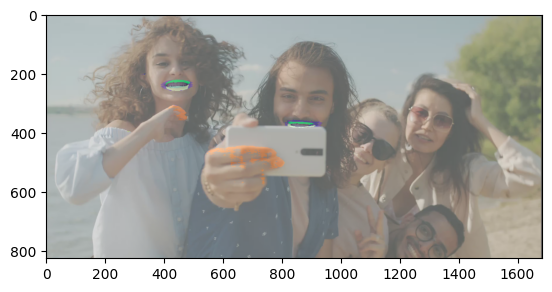

Segmentation inference took: 0.9478 seconds


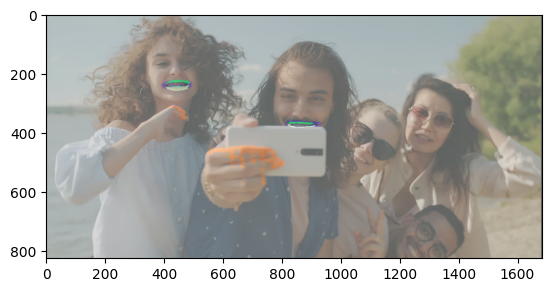

Segmentation inference took: 0.5577 seconds


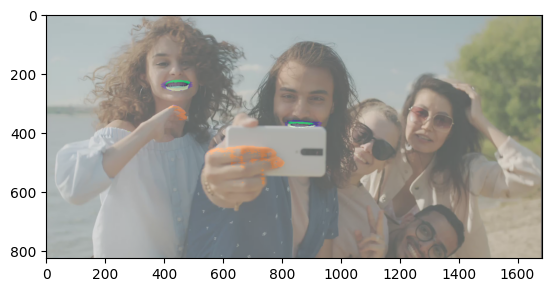

Segmentation inference took: 0.5373 seconds


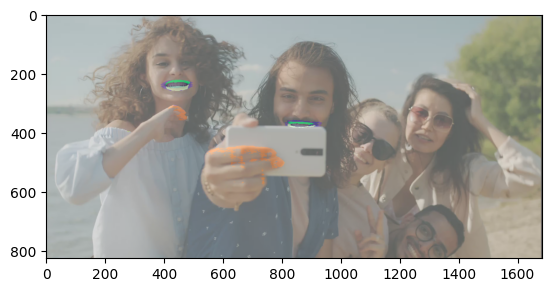

Segmentation inference took: 0.6803 seconds


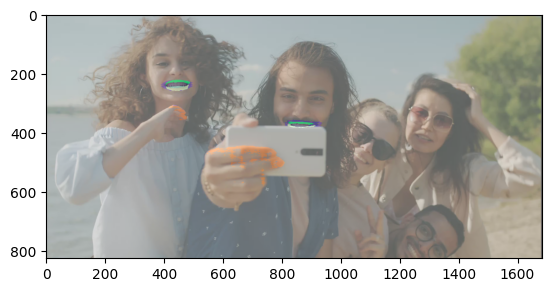

Segmentation inference took: 0.5829 seconds


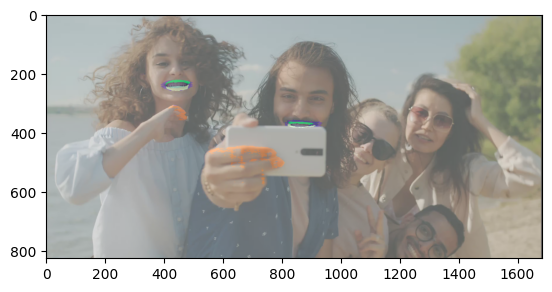

Segmentation inference took: 0.6300 seconds


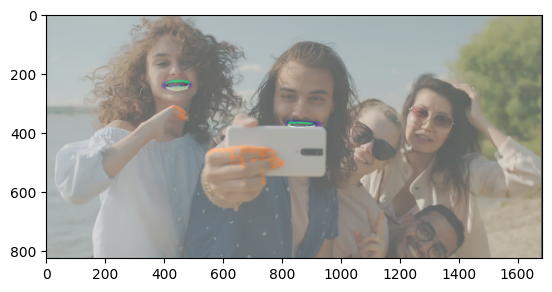

Segmentation inference took: 0.7031 seconds


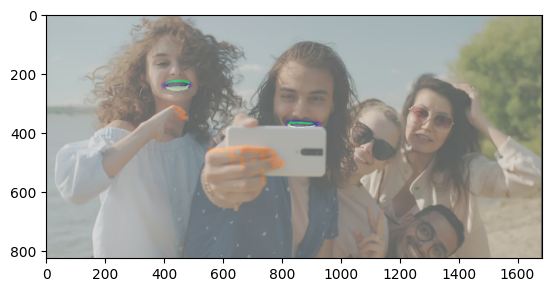

Segmentation inference took: 0.5506 seconds


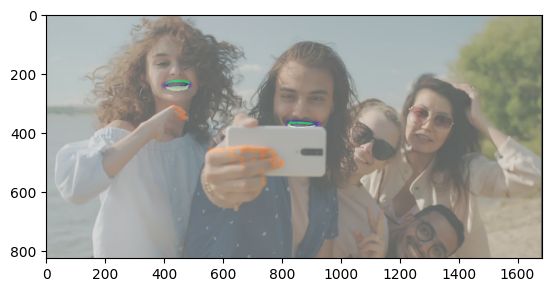

Segmentation inference took: 0.4740 seconds


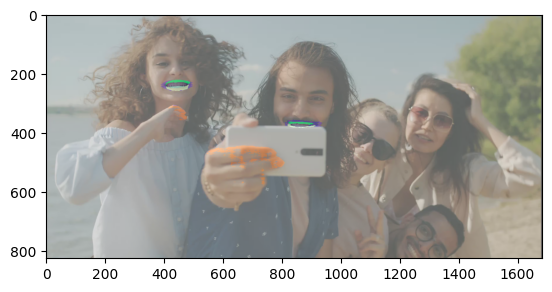

Segmentation inference took: 0.5485 seconds


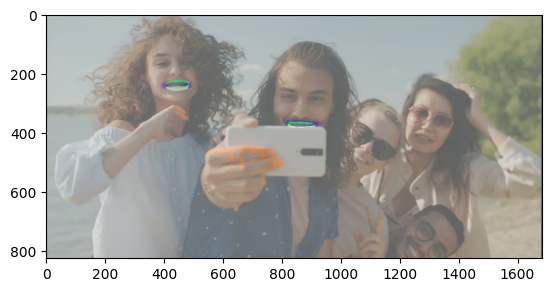

Segmentation inference took: 0.5567 seconds


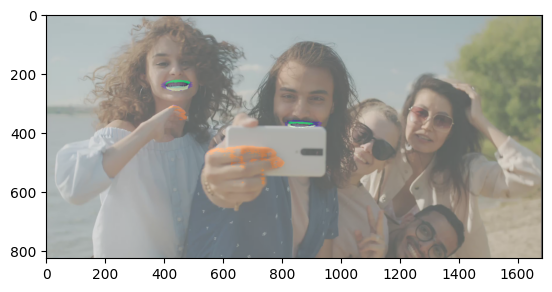

Segmentation inference took: 0.5892 seconds


In [ ]:
# Open the video file
cap = cv2.VideoCapture("test_images/Sapiens-video-test.mp4")

# Get the width, height, and frames per second (fps) of the input video
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)


output_path = "output_segmentation_map.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Initialize the estimator
dtype = torch.float16

# Initialize the depth estimator
model_type = SapiensSegmentationType.SEGMENTATION_1B
estimator = SapiensSegmentation(model_type, dtype = dtype)



while True:
    ret, frame = cap.read()

    if not ret:
        break

    segmentation_map = estimator(frame)

    segmentation_map = draw_segmentation_map(segmentation_map)
    combined = cv2.addWeighted(frame, 0.5, segmentation_map, 0.7, 0)

    segmented_img_rgb = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)

    plt.imshow(segmented_img_rgb)
    plt.show()



    # Write the combined frame to the output video
    out.write(combined)

# Release resources
cap.release()
out.release()